In [144]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.image as mpimg

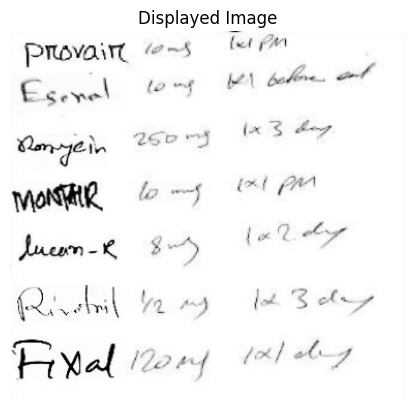

In [145]:
# Image path
image_path = r'perceptions_images\WhatsApp Image 2025-07-03 at 19.55.50_fd416b30.jpg'  # Replace with your actual image path

# Load and show the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Displayed Image")
plt.show()

In [146]:


def create_medicine_area_copy(input_path, output_path=None, width_ratio=0.32):
    """
    Creates a copy of the image containing only the medicine names area and removes the original image.
    
    Args:
        input_path (str): Path to input image
        output_path (str): Optional path for output (default: same directory with '_med' suffix)
        width_ratio (float): Fraction of width to keep (default: 0.32)
    """
    # Read the image
    img = cv2.imread(input_path)
    if img is None:
        raise ValueError(f"Could not read image at {input_path}")
    
    # Crop the left portion (medicine area)
    height, width = img.shape[:2]
    medicine_width = int(width * width_ratio)
    medicine_area = img[:, :medicine_width]
    
    # Determine output path
    if output_path is None:
        dir_name, file_name = os.path.split(input_path)
        name, ext = os.path.splitext(file_name)
        output_path = os.path.join(dir_name, f"{name}_med{ext}")
    
    # Save the cropped image
    success = cv2.imwrite(output_path, medicine_area)
    if not success:
        raise RuntimeError(f"Failed to save image to {output_path}")
    
    # Remove the original image
    os.remove(input_path)
    print(f"Saved medicine area to: {output_path}")
    print(f"Removed original image: {input_path}")

# Example usage
input_image =  r'perceptions_images\WhatsApp Image 2025-07-03 at 19.55.50_fd416b30.jpg'
create_medicine_area_copy(input_image)

Saved medicine area to: perceptions_images\WhatsApp Image 2025-07-03 at 19.55.50_fd416b30_med.jpg
Removed original image: perceptions_images\WhatsApp Image 2025-07-03 at 19.55.50_fd416b30.jpg


In [147]:
# Define the path for saving cropped regions
cropped_images_path = r'cropped_images'
os.makedirs(cropped_images_path, exist_ok=True)  # Ensure the directory exists

# Load the image
images_path = "perceptions_images"


In [148]:
if not os.path.exists(images_path):
    print("Error: Folder not found.")
    exit()


In [149]:
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print("Error: No images found in the folder.")
    exit()

1 boxes extracted and saved in cropped_images!


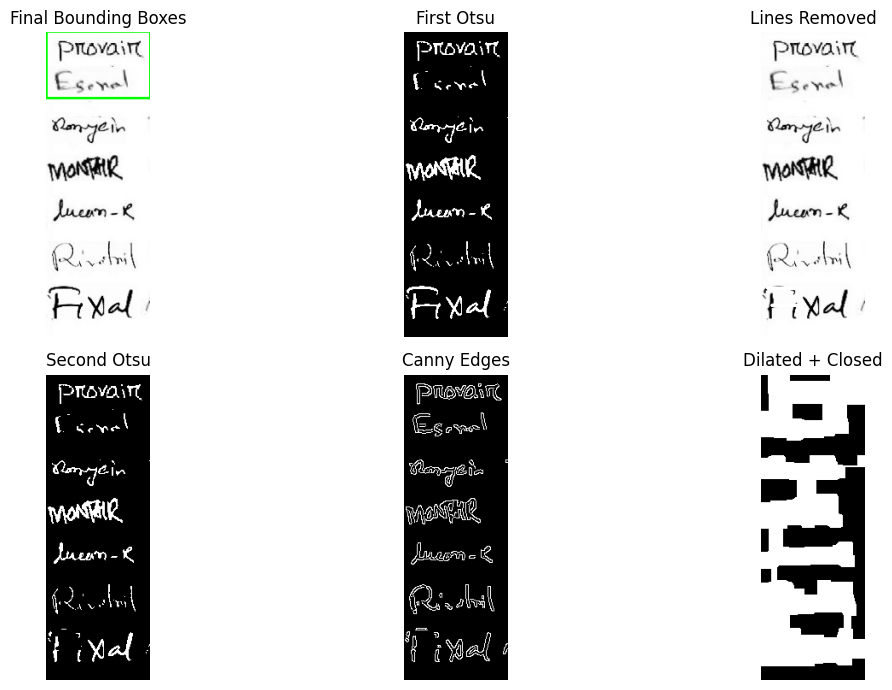

In [150]:
import cv2
import os
import matplotlib.pyplot as plt

for image_file in image_files:
    image_path = os.path.join(images_path, image_file)

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_file}")
        continue  

    original = img.copy()
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Otsu thresholding
    otsu1 = cv2.threshold(grey, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]

    # Remove horizontal lines
    horz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (14, 1))
    lines = cv2.morphologyEx(otsu1, cv2.MORPH_OPEN, horz_kernel, iterations=2)

    cnts, _ = cv2.findContours(lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        cv2.drawContours(img, [c], -1, (255, 255, 255), 2)

    grey_no_lines = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    otsu2 = cv2.threshold(grey_no_lines, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]

    # Gaussian blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(grey_no_lines, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Combine Otsu and edges
    combined = cv2.bitwise_or(otsu2, edges)

    # Dilation to group text components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 11))
    dilation = cv2.dilate(combined, kernel, iterations=1)

    # Morphological closing to close gaps inside text regions
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    closed = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, closing_kernel, iterations=1)

    # Find contours sorted top to bottom
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

    count = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = w / float(h)
        area = w * h
        if w > 30 and h > 20 and 0.5 < aspect_ratio < 5.0 and 1000 < area < 50000:
            count += 1
            cropped = original[y:y + h, x:x + w]
            cropped_output_path = os.path.join(cropped_images_path, f'cropped_{count}.png')
            cv2.imwrite(cropped_output_path, cropped)
            cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)

    print(f"{count} boxes extracted and saved in {cropped_images_path}!")

    # Plotting
    fig, ax = plt.subplots(2, 3, figsize=(13, 7))
    ax = ax.ravel()

    ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Final Bounding Boxes')

    ax[1].imshow(otsu1, cmap='gray')
    ax[1].set_title('First Otsu')

    ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[2].set_title('Lines Removed')

    ax[3].imshow(otsu2, cmap='gray')
    ax[3].set_title('Second Otsu')

    ax[4].imshow(edges, cmap='gray')
    ax[4].set_title('Canny Edges')

    ax[5].imshow(closed, cmap='gray')
    ax[5].set_title('Dilated + Closed')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()



In [151]:
# %% Function to preprocess images for MobileNetV2
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    try:
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image to (224, 224) as MobileNetV2 expects 224x224 images
        image_resized = cv2.resize(image_rgb, (224, 224))

        # Convert to numpy array and preprocess for MobileNetV2
        image_array = np.array(image_resized, dtype=np.float32)
        image_preprocessed = preprocess_input(image_array)

        # Expand dimensions to match model input
        image_expanded = np.expand_dims(image_preprocessed, axis=0)

        return image_expanded, image_rgb
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [152]:
classes = [
    'Aceta', 'Denixil', 'Diflu','Dinafex', 'Disopan', 'Etizin', 'Esoral', 'Esonix', 
    'Exium', 'Fexo', 'Fexofast', 'Fenadin', 'Filmet', 'Fixal', 'Flamyd', 'Flexibac', 
    'Flexilax', 'Flugal', 'Ketoral', 'Ketotab', 'Ketozol', 'Lucan-R', 'Lumona', 
    'Maxima', 'Maxpro', 'Metsina', 'Monas', 'Montair', 'Montene', 'Montex', 'M-Kast', 
    'Napa Extend', 'Nexcap', 'Nidazyl', 'Nizoder', 'Odmon', 'Omastin', 'Opton', 
    'Progut', 'Provair', 'Rhinil', 'Ritch', 'Rivotril', 'Romycin', 'Rozith', 
    'Sergel', 'Tamen', 'Telfast', 'Trilock', 'Vifas', 'Zithrin'
]

model = load_model("final_model.h5")


# Load medicine data from CSV
csv_path = "medications_info.csv"

def load_medicine_data(csv_path):
    df = pd.read_csv(csv_path)

    # Create lookup dictionaries
    alternative_medicines = dict(zip(df['name'], df['alternative_medicine']))
    conflicts = dict(zip(df['name'], df['conflict']))
    dosage = dict(zip(df['name'], df['dosage_mg']))
    form = dict(zip(df['name'], df['form']))
    frequency = dict(zip(df['name'], df['frequency_per_day']))

    return alternative_medicines, conflicts, dosage, form, frequency

# Predict image class and show details
def predict_image(model, image_path, class_names, alternative_medicines, conflicts, dosage, form, frequency):
    # Preprocess the image
    result = preprocess_image(image_path)

    if result is None:
        print("Image preprocessing failed.")
        return

    image_preprocessed, image_rgb = result

    # Predict the class
    prediction = model.predict(image_preprocessed)
    predicted_class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    predicted_class_name = class_names[predicted_class_idx]

    # Look up data
    alt = alternative_medicines.get(predicted_class_name, "No alternatives available")
    conf = conflicts.get(predicted_class_name, "No conflicts listed")
    dose = dosage.get(predicted_class_name, "N/A")
    med_form = form.get(predicted_class_name, "N/A")
    freq = frequency.get(predicted_class_name, "N/A")

    # Print prediction
    print(f"🧠 Predicted Medicine: {predicted_class_name} (Confidence: {confidence:.2f})")
    print(f"💊 Dosage: {dose} mg")
    print(f"📦 Form: {med_form}")
    print(f"⏱️ Frequency: {freq} time(s) per day")
    print(f"🧪 Alternatives: {alt}")
    print(f"⚠️ Conflicts: {conf}")

    # Display image
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class_name}")
    plt.axis('off')
    plt.show()

🔍 Processing: cropped_images\cropped_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
🧠 Predicted Medicine: Fixal (Confidence: 0.55)
💊 Dosage: 400.0 mg
📦 Form: tablet
⏱️ Frequency: 3 time(s) per day
🧪 Alternatives: Ibuprofen,Naproxen,Aspirin
⚠️ Conflicts: Lithium,Diuretics,ACE inhibitors


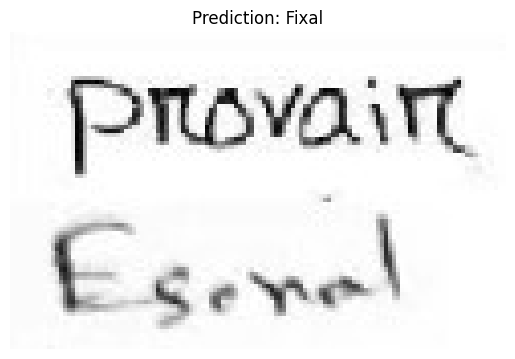

In [153]:
import os
import glob

# Load all medicine data
alternative_medicines, conflicts, dosage, form, frequency = load_medicine_data(csv_path)

# Get all image file paths from the folder
image_paths = glob.glob('cropped_images/*.png')  # Add more extensions if needed
index = 1
# Loop through and predict each image
for image_path in sorted(image_paths[:]):
    print(f"🔍 Processing: {image_path}")
    predict_image(model, image_path, classes,
                  alternative_medicines, conflicts, dosage, form, frequency)
    
